In [1]:
from IPython.display import Markdown, display

display(Markdown("README.md"))

# Exploring Probabilities in War Room by Larry Harris

War Room is a board game by Larry Harris, the designer of Axis and Allies. I see it as at least a spiritual successor to AA, if not a complete overhaul. Like AA, it's a grand strategy game set during World War II. Players control the major Axis and Allied powers and vie for the control of territories. The ultimate goals is to capture the opposing capitals and win the war.

See [main.ipynb](main.ipynb) for the exploration.

I previously did an exploration of battle outcome probabilities in Axis and Allies using JavaScript and C (links below). Battles in War Room are similar in some ways and very different in others. The unit types are mostly identical, but the way dice are rolled and hits are allocated is different. War Room's dice have six different colors distributed across 12 faces. The first four colors: red, green, blue, and yellow correspond to different unit types. The last two colors: black and white, are wild, and may or may not be applied in specific circumstances.

The other big difference from AA is that only one "round" of combat and dice rolling happens per combat per turn. The impact of this rule is that most combats end up playing out over several turns, during which time the territory remains "contested," and players can make plans and moves that reinforce their forces in the territory. I personally like this. I think it reflects the reality of having different "fronts" open in a given region and potentially bogging down as both sides throw more and more resources into the fight.

## Links

- [Codepen: War Room Air/Ground Battle Board Simulator](https://codepen.io/whusterj/full/YzgJdEy/9439d70207e540169361fbbb0e6133e1) - JavaScript implementation of War Room air/ground battle board. Select attacking and defending units and see what might happen.
- [(2020) Explore JavaScript with Axis & Allies](https://williamhuster.com/explore-js-with-axis-and-allies/) - Blog post I wrote breaking down the JavaScript code I wrote to simulate Axis and Allies battles.
- [Codepen: Axis and Allies in JavaScript](https://codepen.io/whusterj/pen/VwvjzQv/b4397c0d26fc315dae283d682f7819d8) - Complete JavaScript implementation of Monte Carlo simulation of Axis and Allies battles.
- [Github: Axis and Allies in C](https://github.com/whusterj/axis-and-allies) - Naive implementation of Axis and Allies battle simulator in C. Tinkering with a focus on execution speed.
- [Board Game Geek: War Room](https://boardgamegeek.com/boardgame/229713/war-room)


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

/var/folders/kh/66486p_9469202_9rm3n31_h0000gn/T/ipykernel_80724/2080034654.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## Part 1 - Modeling the Probabilities Using Simulation

### Step 1 - Set Up the Simulation

Start by setting up the colors for the dice, the number of simulations we want to run, and the number of dice to roll per simulation.

#### Why Ten Dice per Roll?

I've chosen to roll ten dice per simulation of a roll, because the game includes ten dice and the rules suggest that you roll in batches of ten. Because BLACK and WHITE results are wild, this fact can impact how many "hits" are actually allocatable vs ignored.

In [3]:
NUM_SIMULATIONS = 10000
COLORS = ("YELLOW", "BLUE", "GREEN", "RED", "BLACK", "WHITE")
COLOR_LOOKUP = {
    "YELLOW": "#BBBB77",
    "BLUE": "#77AABB",
    "GREEN": "#77BB77",
    "RED": "#BB7777",
    "BLACK": "#222222",
    "WHITE": "#B0B0B0"
}
DIE_FACES = [
    "YELLOW",
    "YELLOW",
    "YELLOW",
    "YELLOW",
    "BLUE",
    "BLUE",
    "BLUE",
    "GREEN",
    "GREEN",
    "RED",
    "BLACK",
    "WHITE"
]
NUM_DICE = 10

### Step 2 - Generate Rolls for Each Simulation

This is very straightforward in Python. We'll use numpy's `random.choice` function to simulate rolling all ten die at once. We'll do this for each simulation. All results are collected into a list of lists and then turned into a pandas DataFrame so we can more easily view, manipulate, and analyze the data.

In [4]:
random_choices = []
for _ in range(NUM_SIMULATIONS):
    choices = np.random.choice(DIE_FACES, size=NUM_DICE)
    random_choices.append(choices)

df_random_choices = pd.DataFrame(random_choices)
df_random_choices


,0,1,2,3,4,5,6,7,8,9
0,YELLOW,BLUE,RED,RED,BLUE,YELLOW,YELLOW,BLUE,YELLOW,GREEN
1,YELLOW,GREEN,BLUE,YELLOW,WHITE,RED,BLUE,BLUE,BLUE,YELLOW
2,YELLOW,YELLOW,GREEN,BLACK,GREEN,BLUE,YELLOW,GREEN,WHITE,YELLOW
3,YELLOW,BLUE,YELLOW,BLUE,YELLOW,YELLOW,BLUE,YELLOW,BLUE,GREEN
4,WHITE,BLUE,YELLOW,YELLOW,BLUE,YELLOW,BLUE,GREEN,GREEN,YELLOW
...,...,...,...,...,...,...,...,...,...,...
9995,BLACK,WHITE,YELLOW,BLUE,YELLOW,YELLOW,BLUE,GREEN,YELLOW,WHITE
9996,BLACK,RED,GREEN,BLUE,GREEN,RED,YELLOW,YELLOW,YELLOW,GREEN
9997,YELLOW,BLUE,YELLOW,BLUE,RED,GREEN,YELLOW,BLACK,BLUE,YELLOW
9998,YELLOW,GREEN,RED,GREEN,BLUE,RED,BLUE,BLACK,GREEN,YELLOW


### Step 3 - Analyze the Results

The proportions of colors on the dice are known, so the expected value for a given roll or set of rules is easy to compute and doesn't require a simulation.

But what is less clear is the *variability* you might expect from each color, and also the aggregate impact of the wild BLACK and WHITE results. So here we look at the distribution by each color.

#### Get and Graph a Distribution for a Color

Here I'm just testing the steps required to aggregate the results of the simulations and plot the distribution of a single color.

In [5]:
yellow_distribution = df_random_choices.apply(lambda row: row.value_counts().get('YELLOW', 0), axis=1)
yellow_distribution

0       4
1       3
2       4
3       5
4       4
       ..
9995    4
9996    3
9997    4
9998    2
9999    4
Length: 10000, dtype: int64

(array([ 177.,  891., 1893., 2688., 2271., 1336.,  546.,  163.,   32.,
           3.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

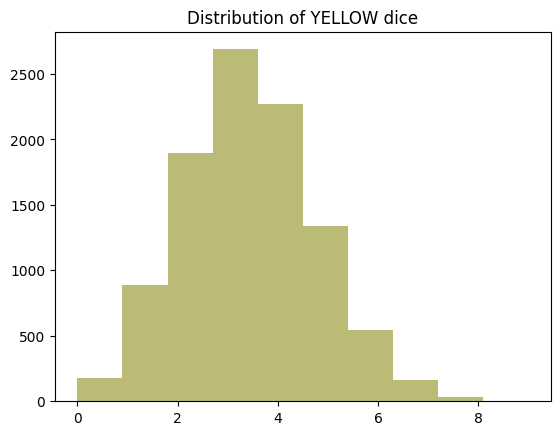

In [6]:
plt.clf()
plt.title("Distribution of YELLOW dice")
plt.hist(yellow_distribution, bins=df_random_choices.shape[1], color=COLOR_LOOKUP["YELLOW"])

#### Aggregate and Plot All Colors

With that figured out for yellow, we can put all colors on the same plot to see how they compare.

<Figure size 640x480 with 0 Axes>

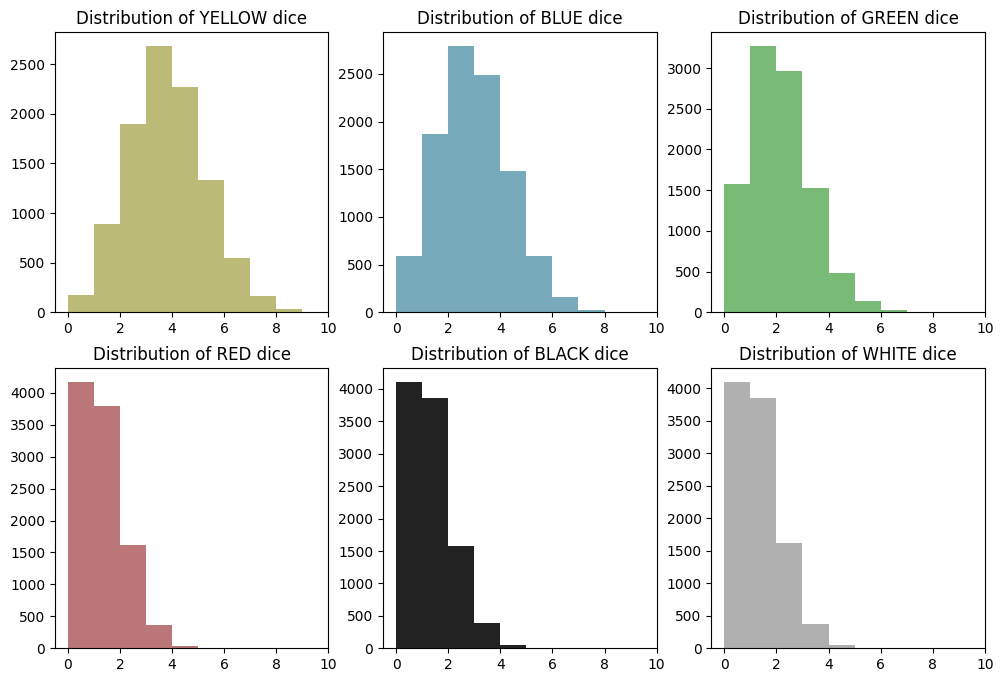

In [7]:
plt.clf()

fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.flatten()

for i, color in enumerate(COLORS):
    distribution = df_random_choices.apply(lambda row: row.value_counts().get(color, 0), axis=1)
    axes[i].hist(distribution, bins=range(df_random_choices.shape[1] + 1), color=COLOR_LOOKUP[color])
    axes[i].set_title(f"Distribution of {color} dice")
    axes[i].set_xlim(right=df_random_choices.shape[1])  # Set max value on x-axis

plt.show()


#### What We See

Distributions appear normally distributed around the expected value for their color. There's a slight skew, because the distributions are discrete and values can't go negative, but the shape is generally normal.

### Step 4 - Adding in White and Black Results

This step is a bit tricky, and the results may not be entirely correct, depending on what you're looking to get out of the problem. My approach here is to add the wild results to all colors. Then we look at the 'before wilds' and 'after wilds' distributions for each color to see how BLACK and WHITE rolls impact the distribution of hits.

In practice you can only apply a wild to one color, not all of them. So doing it this way overstates the total number of hits across all colors. So you should look at the 'after wilds' distributions as a sort of upper bound on the number of hits you might expect.

In [8]:
df_by_color = df_random_choices.apply(lambda row: pd.Series(row.value_counts()).fillna(0), axis=1)
df_by_color.fillna(0, inplace=True)
df_by_color

,BLACK,BLUE,GREEN,RED,WHITE,YELLOW
0,0.0,3.0,1.0,2.0,0.0,4.0
1,0.0,4.0,1.0,1.0,1.0,3.0
2,1.0,1.0,3.0,0.0,1.0,4.0
3,0.0,4.0,1.0,0.0,0.0,5.0
4,0.0,3.0,2.0,0.0,1.0,4.0
...,...,...,...,...,...,...
9995,1.0,2.0,1.0,0.0,2.0,4.0
9996,1.0,1.0,3.0,2.0,0.0,3.0
9997,1.0,3.0,1.0,1.0,0.0,4.0
9998,1.0,2.0,3.0,2.0,0.0,2.0


In [9]:
df_black = df_by_color.pop("BLACK")
df_white = df_by_color.pop("WHITE")
df_by_color

,BLUE,GREEN,RED,YELLOW
0,3.0,1.0,2.0,4.0
1,4.0,1.0,1.0,3.0
2,1.0,3.0,0.0,4.0
3,4.0,1.0,0.0,5.0
4,3.0,2.0,0.0,4.0
...,...,...,...,...
9995,2.0,1.0,0.0,4.0
9996,1.0,3.0,2.0,3.0
9997,3.0,1.0,1.0,4.0
9998,2.0,3.0,2.0,2.0


In [10]:
df_black

0       0.0
1       0.0
2       1.0
3       0.0
4       0.0
       ... 
9995    1.0
9996    1.0
9997    1.0
9998    1.0
9999    2.0
Name: BLACK, Length: 10000, dtype: float64

In [11]:
df_white

0       0.0
1       1.0
2       1.0
3       0.0
4       1.0
       ... 
9995    2.0
9996    0.0
9997    0.0
9998    0.0
9999    0.0
Name: WHITE, Length: 10000, dtype: float64

Next, add the BLACK results to each color. This can be done with simple matrix addition.

In [12]:
df_by_color = df_by_color.add(df_black, axis=0)
df_by_color


,BLUE,GREEN,RED,YELLOW
0,3.0,1.0,2.0,4.0
1,4.0,1.0,1.0,3.0
2,2.0,4.0,1.0,5.0
3,4.0,1.0,0.0,5.0
4,3.0,2.0,0.0,4.0
...,...,...,...,...
9995,3.0,2.0,1.0,5.0
9996,2.0,4.0,3.0,4.0
9997,4.0,2.0,2.0,5.0
9998,3.0,4.0,3.0,3.0


Now add WHITE results. WHITE can only be applied to a unit that has already received a hit. A unit can potentially receive a hit from a same-colored result or a BLACK result. So before adding WHITE to each column, we clip the value based on the number of hits after adding black. This effectively ignores excess WHITE results that couldn't be paired with a colored or BLACK result.

NOTE: It would be interesting to have a look at how many white results end up being ignored.

In [13]:
for color in df_by_color.columns:
    df_white_color = df_white.copy().clip(upper=df_by_color[color])
    df_by_color[color] += df_white_color

df_by_color

,BLUE,GREEN,RED,YELLOW
0,3.0,1.0,2.0,4.0
1,5.0,2.0,2.0,4.0
2,3.0,5.0,2.0,6.0
3,4.0,1.0,0.0,5.0
4,4.0,3.0,0.0,5.0
...,...,...,...,...
9995,5.0,4.0,2.0,7.0
9996,2.0,4.0,3.0,4.0
9997,4.0,2.0,2.0,5.0
9998,3.0,4.0,3.0,3.0


#### Before and After Wilds Comparison

Now we'll re-chart our color distributions from before and compare them to the adjusted distributions after adding BLACK and WHITE results...

<Figure size 640x480 with 0 Axes>

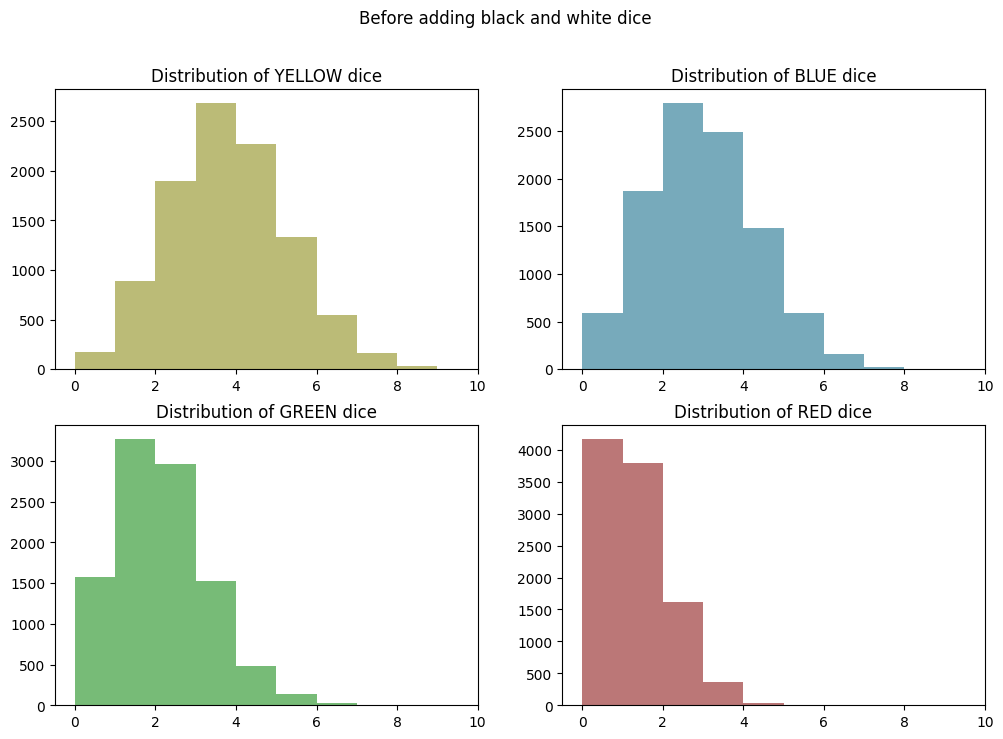

In [14]:
plt.clf()

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for i, color in enumerate(["YELLOW", "BLUE", "GREEN", "RED"]):
    distribution = df_random_choices.apply(lambda row: row.value_counts().get(color, 0), axis=1)
    axes[i].hist(distribution, bins=range(df_random_choices.shape[1] + 1), color=COLOR_LOOKUP[color])
    axes[i].set_title(f"Distribution of {color} dice")
    axes[i].set_xlim(right=df_random_choices.shape[1])  # Set max value on x-axis

plt.suptitle("Before adding black and white dice")
plt.show()

<Figure size 640x480 with 0 Axes>

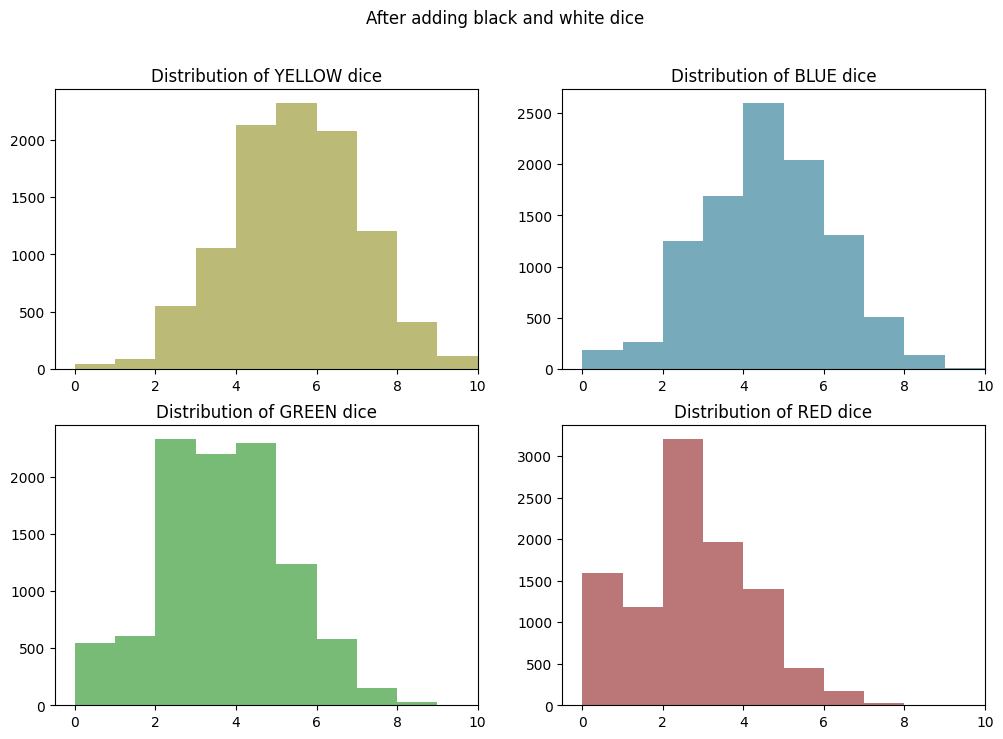

In [15]:
plt.clf()

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for i, color in enumerate(["YELLOW", "BLUE", "GREEN", "RED"]):
    axes[i].hist(df_by_color[color], bins=range(df_random_choices.shape[1] + 1), color=COLOR_LOOKUP[color])
    axes[i].set_title(f"Distribution of {color} dice")
    axes[i].set_xlim(right=df_random_choices.shape[1])  # Set max value on x-axis

plt.suptitle("After adding black and white dice")
plt.show()

### Conclusions - Wild Results Have a Decent Impact!

So it looks like adding in wild results has shifted each distribution up by a little less than two hits. This is to be expected, because both BLACK and WHITE have a 1:12 chance of being rolled, and white is slightly discounted, because it may not always be allocatable.

The impact is most pronounced on green and red. This is because their odds have been improved by a lot: 2X in the case of green (from 2:12 -> ~4:12) and 3X in the case of red (from 1:12 -> ~3:12).

Again, this effectively shows the maximum number of hits you *might* be able to allocate to each indvidual color. In a real game BLACK and WHITE results won't shift all of the colors up by the same amount, because you can only apply a wild to one color at a time. But presumably you would allocate the wild to the color that would benefit the most from it, so this is a reasonable upper bound on the number of hits you might expect to allocate to each color.

## Part 2 - Modeling the Probabilities in "Pure Math"

I'm very familiar with simulation approaches at this point. Practical and imperative math like this also makes a lot of sense to me as a programmer.

So next, I would like to take a more mathematical appraoch to the problem, which is not as natural to me.

I was trying to derive the formula myself while in the shower this morning. It's clear that it's not as simple as looking at the probability of rolling a single color. We need to look at combined probabilities across any number of rolls.

I started by thinking about a specific case: how would you compute the probability that you could roll ten times and end up with zero yellow results? I *know* I studied this back in high school math, but twenty years later it's not exactly top of mind.

I realized that the probability of having no yellow results is the same as rolling non-yellow ten times in a row. That would be something like $(8/12)^{10}$. Not math I can do in my head, but definitely a small number. Using a calculator, there's about a 1.7% chance of this happening. Makes sense.

Then I moved on to the probability of having one out of ten results be yellow, and here I realized that I needed to somehow combine the probability of success with the probability of failure. That's where I got stuck mentally.

### Computing the Binomial Distribution

So I turned to Google and ChatGPT who pointed me at the Binomial Probability formula, which I can use to compute a Binomial Distribution for a given number of dice rolls and a given probability of success.

The formula for Binomial Probability is:

$$P(X = k) = \binom{n}{k} \times p^k \times (1-p)^{n-k}$$

where:
- $n$ is the number of trials (number of die rolls)
- $k$ is the number of successful outcomes (rolling a particular color)
- $p$ is the probability of success on a single trial
- $\binom{n}{k}$ represents the binomial coefficient, which is the number of ways to choose $k$ successes out of $n$ trials

My recollection of this formula from math class is very vague. Looking at it closely, I see that my intuitions were on the right track. The formula is basically using multiplication to combine the probability of getting $k$ successes with the probability of getting $n-k$ failures.

The big piece I was missing and failed to derive for myself was the **binomial coefficient**.

### The Binomial Coefficient

The binomial coefficient is the piece I was missing working through this problem in my head. This is how we can combine the probability $p^k$ of getting $k$ successes with the probability $(1-p)^{n-k}$ of getting $n-k$ failures.

The formula for the binomial coefficient is given by:

$$\binom{n}{k} = \frac{n!}{k! \cdot (n-k)!}$$

where:
- $n!$ denotes the factorial of $n$
- $k!$ denotes the factorial of $k$
- $(n-k)!$ denotes the factorial of $n-k$

Lots of factorials. What do they mean? The question was asked and answered on the [Math Stack Exchange here](https://math.stackexchange.com/questions/3566964/what-is-the-exact-connection-between-binomial-coefficients-and-factorials#:~:text=What%20is%20the%20exact%20connection%20between%20Binomial%20coefficients%20and%20Factorials,-Ask%20Question&text=The%20factorial%20n!%20is%20the,n%20exactly%20k%20of%20them.).

I think I get it, but I don't love these kinds of explanations that are very much grounded in the abstract language of math, rather than a concrete representation of what actually happens in the real world when I toss the dice. To gain a better understanding, let's look at the binomial coefficient in Python.

#### Binomial Coefficient in Python

In Python we could implement a function that computes the binomial coefficient exactly as represented above using `math.factorial`. Python makes it even easier by providing this function in the standard library as `math.comb`.

Remembering that in our case $n$ is the number of dice rolls and $k$ is the number of rolls of a particular color. We can hold $n$ steady at 10 and see how the coefficient varies with $k$. So let's use `NUM_DICE` as $n$ from our simulations above. Then we'll step through every possible value of $k$ successful roles. In math lingo, that is the set of $\{0, 1, 2 ... 10\}$.

In [16]:
import math

n = NUM_DICE
for k in range(n + 1):
    print(k, math.comb(n, k))

0 1
1 10
2 45
3 120
4 210
5 252
6 210
7 120
8 45
9 10
10 1


So here we can see the rise and fall of the distribution in number form. It is centered around 5, because at this point we have not introduced any probabilities. So perhaps we could say that this is the "standard" binomial distribution for 10 dice.

And looking back at the binomial probability formula, we see that this binomial coefficient functions as a way to increase the "weight" of the positive case against the negative case of rolling a particular color. At the center of the distribution it is a heavy weight, indeed. It multiplies the probability of the success case by up to 252 times!

#### A Real Understanding of the Binomial Coefficient

So back to how we can make sense of these numbers... Let's imagine it as cases of throwing ten real dice. For each number of successful yellow rolls $k$, how many different ways can the dice rolls be combined to results in that number?

In the case of zero successful dice rolls of a given color ($k=0$), the binomial coefficient says there's only one way this can happen. This is a little counterintuitive, because I can easily think of many ways that we could roll zero yellow dice: we could roll all blues or all reds or all greens or any combination of those. So this is our first revelation: for the purposes of the binomial coefficient, all those negative cases are treated as the same case, regardless of order or combination of non-yellow results.

Now moving up to $k=1$, there are ten different ways to roll just one yellow die in ten. This is easy to make sense of. We're still ignoring the order, but because there are ten dice, there are ten different combinations of one yellow dice and 9 others: die #1 could be yellow, or die #2, and so on.

At $k=2$, we find there are 45 different ways to roll two yellow dice in ten. We're still ignoring the order, but the possible combinations are quickly adding up. For instance, there are ten combinations of die #1 and the other 9 dice. And then there are nine cases of die #2 and the other 8 dice - note that we already counted the combo of die #1 and die #2. And then there are eight cases of die #3 and the remaining 7 dice, and so on.

Now *that* is starting to look like a factorial. So the formula is helping us compute the sum of these possible combinations for a given number of dice rolls ($n$) and a target number of successful rolls ($k$).

### Computing and Graphing the Probability Distributions

Now let's put it all together in Python and make some more plots...

First, we'll define a function for binomial probability, based on the formula above and using `math.comb` again for the binomial coefficient.

In [17]:
def binomial_probability(n, k, p):
    return math.comb(n, k) * pow(p, k) * pow(1 - p, n - k)

Now, let's set up $n$ and $p_yellow$ then compute the binomial distribution for yellow.

In [18]:
n = NUM_DICE
p_yellow = 4 / 12

yellow_binom_dist = list((k, binomial_probability(n, k, p_yellow)) for k in range(n + 1))
yellow_binom_dist

[(0, 0.017341529915832633),
 (1, 0.08670764957916315),
 (2, 0.19509221155311707),
 (3, 0.26012294873748937),
 (4, 0.22760758014530316),
 (5, 0.13656454808718185),
 (6, 0.05690189503632578),
 (7, 0.016257684296093075),
 (8, 0.0030483158055174507),
 (9, 0.0003387017561686056),
 (10, 1.693508780843028e-05)]

Again, we see the rise and fall of the distribution in number form and that the peak is slightly shifted towards zero and centered on 3-4 successes, as we saw in the earlier simulation and would expect from the underlying probabilities.

We also see that the probabilities sum to 1.0 (allowing for some floating point error):

In [19]:
sum(prob for k, prob in yellow_binom_dist)

1.0000000000000007

Now let's plot this distribution side-by-side with the simulation results from earlier:

<Figure size 640x480 with 0 Axes>

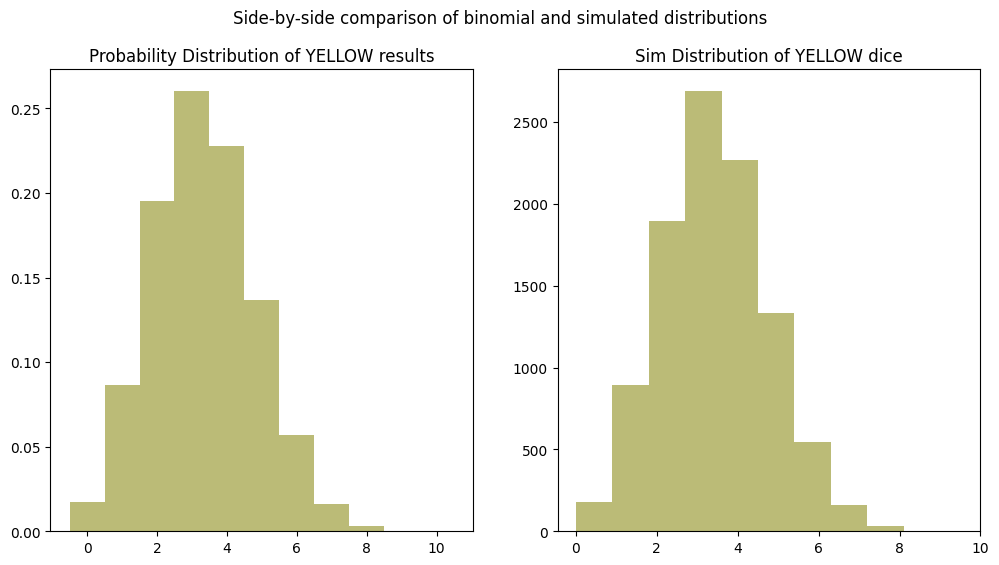

In [20]:
plt.clf()

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes = axes.flatten()

x_values, y_values = zip(*yellow_binom_dist)
axes[0].set_title("Probability Distribution of YELLOW results")
axes[0].bar(x_values, y_values, align='center', color=COLOR_LOOKUP["YELLOW"], width=1)

axes[1].set_title(f"Sim Distribution of YELLOW dice")
axes[1].hist(yellow_distribution, bins=10, color=COLOR_LOOKUP["YELLOW"])
axes[1].set_xlim(right=10)

plt.suptitle("Side-by-side comparison of binomial and simulated distributions")
plt.show()

As expected, the distributions look identical!

### Including Wild Results

We can follow the same approach to compute our probability distribution for the number of BLACK results.

<Figure size 640x480 with 0 Axes>

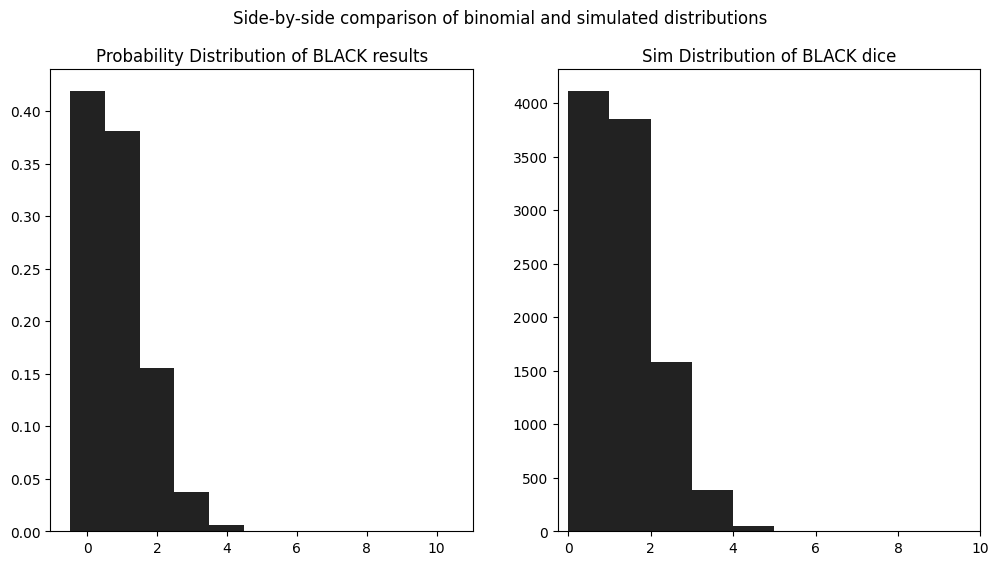

In [21]:
b_prob = 1 / 12
black_binom_dist = list((k, binomial_probability(n, k, b_prob)) for k in range(n + 1))

plt.clf()

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes = axes.flatten()

x_values, y_values = zip(*black_binom_dist)
axes[0].set_title("Probability Distribution of BLACK results")
axes[0].bar(x_values, y_values, align='center', color=COLOR_LOOKUP["BLACK"], width=1)

black_distribution = df_random_choices.apply(lambda row: row.value_counts().get("BLACK", 0), axis=1)
axes[1].set_title(f"Sim Distribution of BLACK dice")
axes[1].hist(black_distribution, bins=10, color=COLOR_LOOKUP["BLACK"], width=1)
axes[1].set_xlim(right=10)

plt.suptitle("Side-by-side comparison of binomial and simulated distributions")
plt.show()

Now at first I thought that we should somehow combine this distribution with the yellow distribution through addition or multiplication, but I realize that wouldn't be correct. The BLACK results really modify the probability of a success ($p$) in the binomial probability function.

So this is actually fairly simple, I think, we must recompute the binomial distribution with a higher value for $p$.

<BarContainer object of 11 artists>

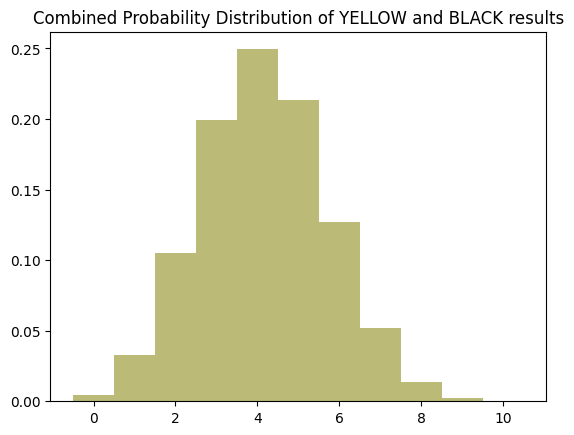

In [22]:
y_and_b_prob = 5 / 12

yellow_and_black_binom_dist = list((k, binomial_probability(n, k, y_and_b_prob)) for k in range(n + 1))

plt.clf()
x_values, y_values = zip(*yellow_and_black_binom_dist)
plt.title("Combined Probability Distribution of YELLOW and BLACK results")
plt.bar(x_values, y_values, align='center', color=COLOR_LOOKUP["YELLOW"], width=1)

So we see that this has shifted the distribution to the right a bit by approximately 1 hit.

#### How to Add WHITE Results?

This seems tricky, and I have not had time to figure out the mathematical formulation for this.

It's tricky because WHITE results are *not* independent of YELLOW and BLACK results. They can only be counted in cases where one of the others is already present. In the simulation I accounted for this by clipping the number of WHITE results based on the number of hits after adding BLACK results.

If I have time I'll revisit this.

##### The Impact of Adding WHITE Results

Looking at the simulation results, it seems like adding white results shifts the distribution to the right and also "crushes" the center of the distribution, resulting in a flatter peak and less overall variability around the center.

So adding WHITE results does not simply increase the probability of a hit. It changes the whole character of the distribution.

We can see this by running the numbers with a slightly higher probability to represent adding WHITE dice.

In [23]:
n = NUM_DICE
y_or_b_prob = 5.5 / 12

yellow_and_wilds_binom_dist = []
for k in range(n + 1):
    yellow_and_wilds_binom_dist.append((k, binomial_probability(n, k, y_or_b_prob)))

yellow_and_wilds_binom_dist

[(0, 0.0021743082111706858),
 (1, 0.018397992556059645),
 (2, 0.07005389473268862),
 (3, 0.15807032657632303),
 (4, 0.23406567589186295),
 (5, 0.23766668629019927),
 (6, 0.16758548392257636),
 (7, 0.0810303438746523),
 (8, 0.02571155142176466),
 (9, 0.004834650694690791),
 (10, 0.0004090858280122976)]

In [24]:
sum(prob for k, prob in yellow_and_wilds_binom_dist)

1.0000000000000004

<Figure size 640x480 with 0 Axes>

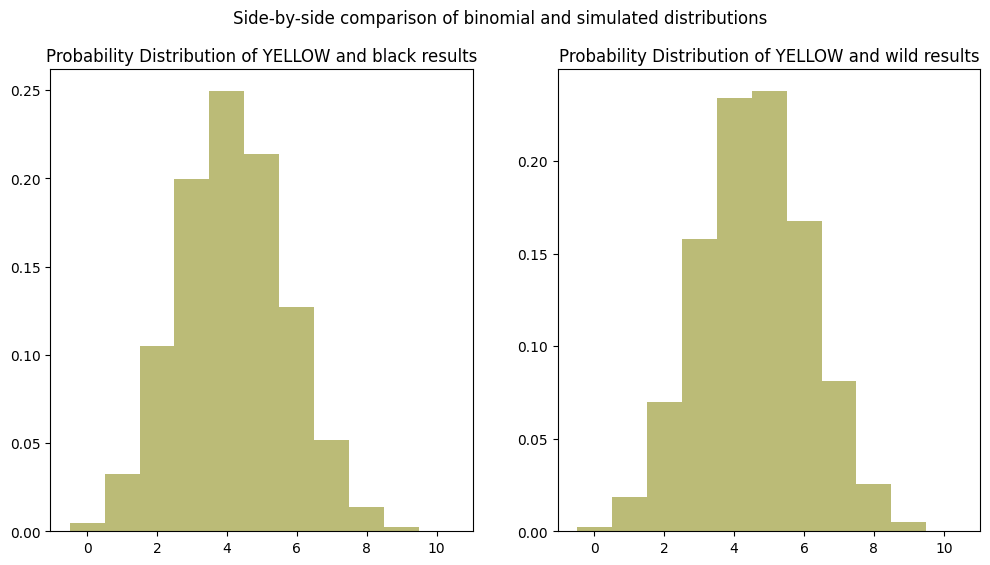

In [25]:
plt.clf()

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes = axes.flatten()

x1_values, y1_values = zip(*yellow_and_black_binom_dist)
axes[0].set_title("Probability Distribution of YELLOW and black results")
axes[0].bar(x1_values, y1_values, align='center', color=COLOR_LOOKUP["YELLOW"], width=1)

x2_values, y2_values = zip(*yellow_and_wilds_binom_dist)
axes[1].set_title("Probability Distribution of YELLOW and wild results")
axes[1].bar(x2_values, y2_values, align='center', color=COLOR_LOOKUP["YELLOW"], width=1)

plt.suptitle("Side-by-side comparison of binomial and simulated distributions")
plt.show()

Looking back at the YELLOW graph from our simulation results above, we can clearly see the shape of this distribution is more "sharp" at the peak than it should be, while the simulation resulted in a flatter peak. This shows that there must be a better way to mathematically model the impact of WHITE results. I'll have to come back to this.